# Ethics attitudes
This notebook is for comparing out results to UofT

In [6]:
import pandas as pd
import numpy as np
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns
import plot_likert
import starbars 

import os
import sys
import yaml
from IPython.display import display

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from scripts import utils

plot_likert.__internal__.BAR_LABEL_FORMAT = "%.1f" # plotting shows % with 2 decimals

# ignore plotting warnings to save space
import warnings
warnings.filterwarnings('ignore')

In [7]:
# vars
likert = range(1, 8)
likert_values = ["Strongly Disagree", "Disagree", "Somewhat Disagree", "Neutral", "Somewhat Agree", "Agree", "Strongly Agree"]
attitudes = ["Interest", "Value", "Self-efficacy", "Responsibility"]

# current semester (for script purposes)
semester = "F2025"

In [8]:
data_dir = os.path.join(project_root, 'data')

ee_file = "F2025_ee_clean.csv"
cg_file = "F2025_cg_clean.csv"
questions_file = f"{semester}_survey.yaml"

ee_data_path = os.path.join(data_dir, 'clean', ee_file)
cg_data_path = os.path.join(data_dir, 'clean', cg_file)

In [9]:
ee_data_full = pd.read_csv(ee_data_path, header=[0,1], index_col=0)

# remove rows with students who did not attend EE
ee_data = ee_data_full[ee_data_full["EE course"]["None"] == 0]

cg_data_full = pd.read_csv(cg_data_path, header=[0,1], index_col=0)

# add the students who did not attend EE to control group
cg_data = pd.concat([cg_data_full, ee_data_full[ee_data_full["EE course"]["None"] == 1]], axis=0)

data_all = {"EE": ee_data, 
            "CG": cg_data}

# rebuild the multiindexing properly to make data access easier
for d in data_all:
    utils.rebuild_multiindex(data_all[d])

# get survey questions
with open(os.path.join(data_dir, questions_file), 'r') as yaml_file:
    questions = yaml.safe_load(yaml_file)

## Comparision with [2022 paper](https://doi.org/10.1145/3478431.3499407). 

Questions that were asked to students in their 2022 study.

In [10]:
questions_2022 = ["Interest Q1", "Interest Q5", "Self-efficacy Q1", "Self-efficacy Q3", "Self-efficacy Q4", "Self-efficacy Q5"]
for i, q in enumerate(questions_2022):
    print(f"{i+1}. {questions[q]}")

1. I am interested in learning more about ethical issues in technology
2. I think about how ethical issues arising from technology may come into play in my career
3. I feel equipped to identify ethical issues arising from technology
4. I have the skills to carry on a meaningful conversation about ethical issues arising from technology
5. I feel empowered to raise ethical issues arising from technology that may arise in my career
6. I have the capability to take action in response to ethical issues arising from technology, such as suggesting a design modification or requesting that the issue be brough forward for review


Get the data that matches UofT's questions

In [11]:
# post data for UofT
uoft_2022_dict = {"group": ["EE group", "Control group"],
                  "mean": [32.39, 28.21],
                  "stdev": [5.87, 7.15]}
uoft_2022 = pd.DataFrame(uoft_2022_dict)
uoft_2022 = uoft_2022.assign(Group="UofT")

In [12]:
mcgill_data_2022 = {}
mcgill_avg_2022 = []
mcgill_std_2022 = []

for group in data_all:
    data = pd.DataFrame()
    for q in questions_2022:
        attitude, q_num = q.split()
        data = pd.concat([data, data_all[group][attitude][q_num]], axis=1)
    mcgill_data_2022[group] = data
    mcgill_avg_2022.append(data.sum(axis=1).mean())
    mcgill_std_2022.append(data.sum(axis=1).std())

mcgill_2022_dict = {"group": ["EE group", "Control group"],
                  "mean": mcgill_avg_2022,
                  "stdev": mcgill_std_2022}

mcgill_2022 = pd.DataFrame(mcgill_2022_dict)
mcgill_2022 = mcgill_2022.assign(Group="McGill")

#### EE vs CG differences at McGill
Check whether there is a statistically significant difference between EE and CG group for McGill. 
UofT did a 2-sample Welch t-test.

1. Check for equal variance

In [13]:
mcgill_avg_summed_2022 = {}
for d in mcgill_data_2022:
    mcgill_avg_summed_2022[d] = pd.DataFrame({"EASE score":mcgill_data_2022[d].sum(axis=1)})

In [14]:
equal_var_mcgill_2022 = utils.equal_var_test([mcgill_avg_summed_2022["EE"], mcgill_avg_summed_2022["CG"]], ["EASE score"])
display(equal_var_mcgill_2022)

,W,pval,equal_var
EASE score,1.786111,0.184184,True


2. Check for normality

In [15]:
for d in mcgill_avg_summed_2022:
    norm_test = pg.normality(mcgill_avg_summed_2022[d], method="shapiro")
    print(f"Normality test for {d} group")
    display(norm_test)

Normality test for EE group


,W,pval,normal
EASE score,0.974256,0.367469,True


Normality test for CG group


,W,pval,normal
EASE score,0.968792,0.109902,True


3. Perform t-test. 

Note that this function automatically picks the Welch test when sample sizes are unequal, so the parametric version matches UofT in this case. 

In [16]:
ttest_mcgill_2022, mwu_mcgill_2022 = utils.ttest(mcgill_avg_summed_2022["EE"], mcgill_avg_summed_2022["CG"], ["EASE score"])

print("Parametric t-test")
display(ttest_mcgill_2022)
print("Non-parametric t-test (Mann-Whitney U Test)")
display(mwu_mcgill_2022)

Parametric t-test


,T,dof,alternative,p-val,significance,CI95%,cohen-d,BF10,power
EASE score,2.510508,92.133975,two-sided,0.013799,*,"[0.6, 5.1]",0.491406,3.268,0.719813


Non-parametric t-test (Mann-Whitney U Test)


,U-val,alternative,p-val,significance,RBC,CLES
EASE score,1958.5,two-sided,0.007832,**,0.295304,0.647652


Plot results

In [17]:
data_2022 = pd.concat([mcgill_2022, uoft_2022])
data_2022.rename(columns={"Group":"institution"}, inplace=True)

1.9800000000000002 0.03
1.9800000000000002 0.03


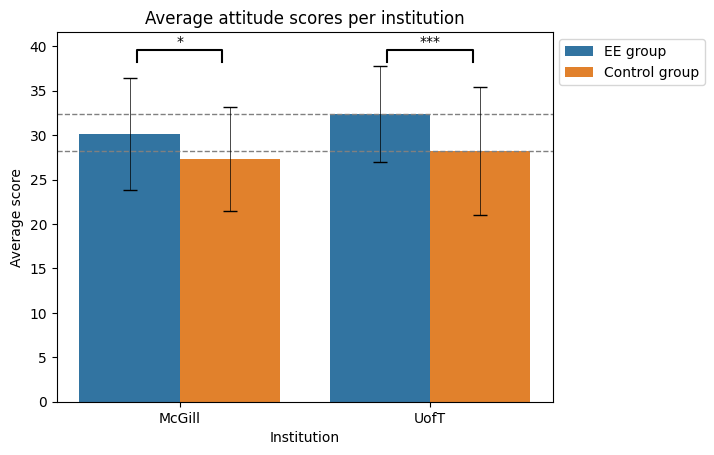

In [29]:
ax = sns.barplot(
    data=data_2022,
    x="institution",
    y="mean",
    hue="group"
)

plt.axhline(y=uoft_2022["mean"][0], linewidth=1, linestyle='dashed', color='grey')
plt.axhline(y=uoft_2022["mean"][1], linewidth=1, linestyle='dashed', color='grey')

# put error bars manually (from chatgpt)
for bar, err in zip(ax.patches, data_2022["stdev"]):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax.errorbar(
        x, y, yerr=err,
        fmt="none",
        ecolor="black",
        elinewidth=0.5,
        capsize=5
    )

ax.set_title("Average attitude scores per institution")
ax.set_xlabel("Institution")
ax.set_ylabel("Average score")
plt.yticks(range(0, 46, 5))
ax.legend(loc='upper right', bbox_to_anchor=(1.32, 1))

annotations = [(("EE group", "McGill"), ("Control group", "McGill"), ttest_mcgill_2022["p-val"].values[0]),
               (("EE group", "UofT"), ("Control group", "UofT"), 0.0009)]
starbars.draw_annotation(annotations, bar_gap=-0.15)

## Comparison with 2023 paper.

Questions that were asked to students in their 2022 study.

In [ ]:
mcgill_ee_attitude_data_2023 = pd.concat([ee_data["Interest"][["Q1", "Q5"]], ee_data["Value"][["Q1", "Q2"]], ee_data["Responsibility"][["Q1"]]], axis=1)
mcgill_cg_attitude_data_2023 = pd.concat([cg_data["Interest"][["Q1", "Q5"]], cg_data["Value"][["Q1", "Q2"]], cg_data["Responsibility"][["Q1"]]], axis=1)
mcgill_ee_se_data_2023 = ee_data["Self-efficacy"][["Q1", "Q3", "Q4", "Q5"]]
mcgill_cg_se_data_2023 = cg_data["Self-efficacy"][["Q1", "Q3", "Q4", "Q5"]]

In [34]:
att_questions_2023 = ["Interest Q1", "Interest Q5", "Value Q1", "Value Q2", "Responsibility Q1"]
se_questions_2023 = ["Self-efficacy Q1", "Self-efficacy Q3", "Self-efficacy Q4", "Self-efficacy Q5"]
questions_2023 = {"Attitudes": att_questions_2023,
                  "Self-efficacy": se_questions_2023}
for attitudes in questions_2023:
    print(f"---- {attitudes} questions ----")
    for i, q in enumerate(questions_2023[attitudes]):
        print(f"{i+1}. {questions[q]}")
    

---- Attitudes questions ----
1. I am interested in learning more about ethical issues in technology
2. I think about how ethical issues arising from technology may come into play in my career
3. All computer science students should learn about ethical issues arising from technology as part of their computer science program
4. It is important for computer scientists to consider ethical issues arising from technology in their work
5. Technology is having an impact on society that raises ethical issues
---- Self-efficacy questions ----
1. I feel equipped to identify ethical issues arising from technology
2. I have the skills to carry on a meaningful conversation about ethical issues arising from technology
3. I feel empowered to raise ethical issues arising from technology that may arise in my career
4. I have the capability to take action in response to ethical issues arising from technology, such as suggesting a design modification or requesting that the issue be brough forward for rev

Get the data that matches UofT's questions

In [69]:
# post data for UofT
uoft_att_2023_dict = {"group": ["EE group", "Control group"],
                      "mean": [28.22, 27.02],
                      "stdev": [5.28, 5.65]}
uoft_att_2023 = pd.DataFrame(uoft_att_2023_dict)
uoft_att_2023 = uoft_att_2023.assign(Group="UofT")

uoft_se_2023_dict = {"group": ["EE group", "Control group"],
                      "mean": [19.52, 17.87],
                      "stdev": [4.71, 4.96]}
uoft_se_2023 = pd.DataFrame(uoft_se_2023_dict)
uoft_se_2023 = uoft_se_2023.assign(Group="UofT")

uoft_2023 = {"Attitudes": uoft_att_2023,
             "Self-efficacy": uoft_se_2023}

In [56]:
mcgill_2023 = {}
mcgill_data_2023 = {}

for att in questions_2023:
    # data per attitude
    mcgill_data_attitude_2023 = {}
    mcgill_avg_attitude_2023 = []
    mcgill_std_attitude_2023 = []

    for group in data_all:
        data = pd.DataFrame()
        for q in questions_2023[att]:
            attitude, q_num = q.split()
            data = pd.concat([data, data_all[group][attitude][q_num]], axis=1)

        mcgill_data_attitude_2023[group] = data
        mcgill_avg_attitude_2023.append(data.sum(axis=1).mean())
        mcgill_std_attitude_2023.append(data.sum(axis=1).std())

    mcgill_2023_dict = {"group": ["EE group", "Control group"],
                    "mean": mcgill_avg_attitude_2023,
                    "stdev": mcgill_std_attitude_2023}

    # put all numbers in dataframe
    mcgill_attitude_2023 = pd.DataFrame(mcgill_2023_dict)
    mcgill_attitude_2023 = mcgill_attitude_2023.assign(Group="McGill")

    mcgill_2023[att] = mcgill_attitude_2023
    mcgill_data_2023[att] = mcgill_data_attitude_2023

#### EE vs CG differences at McGill
Check whether there is a statistically significant difference between EE and CG group for McGill. 
UofT did a 2-sample Welch t-test.

1. Check for equal variance

In [58]:
mcgill_avg_summed_2023 = {}

for att in questions_2023:
    mcgill_avg_summed_att_2023 = {}
    for d in mcgill_data_2023[att]:
        mcgill_avg_summed_att_2023[d] = pd.DataFrame({"EASE score": mcgill_data_2023[att][d].sum(axis=1)})
    mcgill_avg_summed_2023[att] = mcgill_avg_summed_att_2023

In [59]:
for att in questions_2023:
    equal_var_mcgill_2023 = utils.equal_var_test([mcgill_avg_summed_2023[att]["EE"], mcgill_avg_summed_2023[att]["CG"]], ["EASE score"])
    print(f"Equal variance test for {att}")
    display(equal_var_mcgill_2023)

Equal variance test for Attitudes


,W,pval,equal_var
EASE score,0.893269,0.346683,True


Equal variance test for Self-efficacy


,W,pval,equal_var
EASE score,1.840675,0.177675,True


2. Check for normality

In [62]:
for att in questions_2023:
    print(f"---- Normality test for {att} ----")

    for d in mcgill_avg_summed_2023[att]:
        norm_test = pg.normality(mcgill_avg_summed_2023[att][d], method="shapiro")
        print(f"{d} group")
        display(norm_test)

---- Normality test for Attitudes ----
EE group


,W,pval,normal
EASE score,0.89941,0.000602,False


CG group


,W,pval,normal
EASE score,0.867224,0.000007,False


---- Normality test for Self-efficacy ----
EE group


,W,pval,normal
EASE score,0.96412,0.148046,True


CG group


,W,pval,normal
EASE score,0.974546,0.215792,True


3. Perform t-test. 

Note that this function automatically picks the Welch test when sample sizes are unequal, so the parametric version matches UofT in this case. 

In [68]:
for att in questions_2023:
    print(f"---- T-test for {att} ----")

    ttest_mcgill_2023, mwu_mcgill_2023 = utils.ttest(mcgill_avg_summed_2023[att]["EE"], mcgill_avg_summed_2023[att]["CG"], ["EASE score"])

    print("Parametric t-test")
    display(ttest_mcgill_2023)
    print("Non-parametric t-test (Mann-Whitney U Test)")
    display(mwu_mcgill_2023)

---- T-test for Attitudes ----
Parametric t-test


,T,dof,alternative,p-val,significance,CI95%,cohen-d,BF10,power
EASE score,0.549162,107.456175,two-sided,0.584033,ns,"[-1.36, 2.4]",0.103032,0.232,0.083136


Non-parametric t-test (Mann-Whitney U Test)


,U-val,alternative,p-val,significance,RBC,CLES
EASE score,1572.5,two-sided,0.71933,ns,0.040013,0.520007


---- T-test for Self-efficacy ----
Parametric t-test


,T,dof,alternative,p-val,significance,CI95%,cohen-d,BF10,power
EASE score,3.676429,95.25067,two-sided,0.000391,***,"[1.52, 5.1]",0.714721,69.355,0.958847


Non-parametric t-test (Mann-Whitney U Test)


,U-val,alternative,p-val,significance,RBC,CLES
EASE score,2098.0,two-sided,0.000472,***,0.387566,0.693783


Plot results

1.9800000000000002 0.03
1.9800000000000002 0.03
1.9800000000000002 0.03


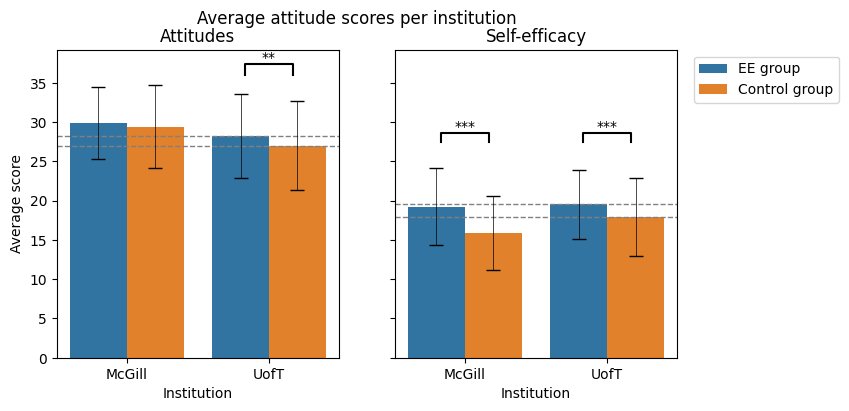

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
for i, att in enumerate(questions_2023):
    data_2023 = pd.concat([mcgill_2023[att], uoft_2023[att]])
    data_2023.rename(columns={"Group":"institution"}, inplace=True)

    ax = sns.barplot(
        data=data_2023,
        x="institution",
        y="mean",
        hue="group",
        ax=axes[i]
    )

    ax.axhline(y=uoft_2023[att]["mean"][0], linewidth=1, linestyle='dashed', color='grey')
    ax.axhline(y=uoft_2023[att]["mean"][1], linewidth=1, linestyle='dashed', color='grey')

    # put error bars manually (from chatgpt)
    for bar, err in zip(ax.patches, data_2023["stdev"]):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()

        ax.errorbar(
            x, y, yerr=err,
            fmt="none",
            ecolor="black",
            elinewidth=0.5,
            capsize=5
        )

    ax.set_title(att)
    ax.set_xlabel("Institution")
    ax.set_ylabel("Average score")
    plt.yticks(range(0, 46, 5))
       

fig.suptitle("Average attitude scores per institution")

annotations = [(("EE group", "UofT"), ("Control group", "UofT"), 0.009)]
starbars.draw_annotation(annotations, bar_gap=-0.2, ax=axes[0])

annotations = [(("EE group", "McGill"), ("Control group", "McGill"), 0.0009),
                (("EE group", "UofT"), ("Control group", "UofT"), 0.0009)]
starbars.draw_annotation(annotations, bar_gap=-0.3, ax=axes[1])

axes[0].legend_.remove()
axes[1].legend(loc='upper right', bbox_to_anchor=(1.6, 1))
